In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/drive/My Drive/ML/PROJECT/"

os.chdir(root_dir)
#os.listdir(root_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from numpy import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from skimage import io, color
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import time
import os
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
#import scikitplot as skplt

# 1.Load Data

In [4]:
df = pd.read_csv('final_data_cleaned.csv')
print(df.shape)
df.head()

(3147, 102)


,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,TOTAL_MALE,TOTAL_FEMALE,PERCENT_FEMALE,PERCENT_MALE,AGEUNDER15,AGE35_44,AGE45_54,AGE65_74,AGE_75OVER,PERCENT_TOTALPOP,INCOME_PERCAPITA,WORKERS 16 YEARS AND OVER,"CAR, TRUCK, OR VAN","WORKERS PER CAR, TRUCK, OR VAN",PUBLIC TRANSPORTATION (EXCLUDING TAXICAB),WALKED,BICYCLE,"TAXICAB, MOTORCYCLE, OR OTHER MEANS",WORKED AT HOME,WORKED OUTSIDE COUNTY OF RESIDENCE,WORKED OUTSIDE STATE OF RESIDENCE,WORKERS 16 YEARS AND OVER WHO DID NOT WORK AT HOME,LESS THAN 10 MINUTES,10 TO 14 MINUTES,15 TO 19 MINUTES,20 TO 24 MINUTES,25 TO 29 MINUTES,30 TO 34 MINUTES,35 TO 44 MINUTES,45 TO 59 MINUTES,...,LAB_16-19,LAB_20-24,LAB_25-29,LAB_30-34,LAB_35-44,LAB_45-54,LAB_55-59,LAB_60-64,LAB_65-74,LAB_OVER75,EMPLOYMENT/POPULATION_RATIO,EMP_16-19,EMP_20-24,EMP_25-29,EMP_30-34,EMP_35-44,EMP_45-54,EMP_55-59,EMP_60-64,EMP_65-74,EMP_OVER75,UNEMPLOYMENT_RATE,UNEMP_16-19,UNEMP_20-24,UNEMP_25-29,UNEMP_30-34,UNEMP_35-44,UNEMP_45-54,UNEMP_55-59,UNEMP_60-64,UNEMP_65-74,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),INFECTION RATE,POP DENSITY
0,0500000US01001,Autauga County,Alabama,55200.0,7.0,6.0,6.6,6.2,7.5,4.9,26874.0,28326.0,51.315217,48.684783,19.7,13.3,14.2,8.5,6.1,0.017095,29372.0,24428.0,95.2,1.05,0.1,0.6,0.1,1.3,2.8,64.5,0.6,23753.0,12.8,10.5,14.2,13.8,9.5,20.0,7.4,6.0,...,31.9,70.8,83.0,81.9,78.9,74.9,66.2,52.1,15.1,2.5,55.6,27.4,61.7,77.0,76.2,72.1,72.7,65.3,50.4,14.8,2.5,4.2,14.2,12.7,3.6,3.7,3.6,2.4,1.4,3.2,1.5,0.0,64.150362,34.150362,37.731884,60.568841,26.865672,598.73,0.034420,92.195146
1,0500000US01003,Baldwin County,Alabama,208107.0,6.1,5.2,5.7,5.5,6.9,7.1,101188.0,106919.0,51.376936,48.623064,18.2,12.2,13.6,11.8,7.7,0.064449,31203.0,91420.0,91.7,1.05,0.1,0.7,0.1,1.3,6.1,20.6,6.0,85813.0,10.6,13.2,14.1,13.4,6.6,17.3,7.0,9.9,...,39.1,77.1,81.3,78.8,81.3,80.5,69.3,48.8,22.6,5.6,55.7,33.8,69.6,73.5,76.7,78.8,76.9,68.3,47.8,21.9,5.4,4.4,13.5,9.7,8.6,2.2,2.4,4.4,1.4,2.0,3.2,2.6,72.480022,28.537243,35.510098,65.507167,26.865672,1737.68,0.031714,119.761406
2,0500000US01005,Barbour County,Alabama,25782.0,5.6,6.4,7.2,7.0,6.4,6.4,13697.0,12085.0,46.873788,53.126212,17.6,12.0,13.4,11.0,7.0,0.007984,18461.0,8538.0,94.2,1.07,0.3,2.1,0.0,2.1,1.3,20.9,4.7,8427.0,25.4,16.0,12.6,10.9,4.7,10.8,3.4,8.1,...,22.4,57.2,72.0,48.3,54.4,59.7,51.7,44.6,27.1,6.6,41.6,16.3,50.4,57.4,41.5,49.3,56.4,49.9,44.1,26.2,6.0,9.5,27.2,11.9,20.3,14.1,9.4,5.4,3.4,1.2,3.0,9.2,40.745481,45.857575,49.169964,37.433093,26.865672,891.30,0.034908,28.926287
3,0500000US01007,Bibb County,Alabama,22527.0,6.7,6.6,6.9,6.7,6.6,5.4,12152.0,10375.0,46.055844,53.944156,16.7,12.9,15.2,9.4,6.9,0.006976,20199.0,7946.0,95.5,1.06,0.5,0.6,0.0,0.9,2.6,64.3,0.5,7738.0,10.4,14.1,10.3,8.5,5.0,12.1,14.5,16.2,...,16.9,58.4,56.6,58.1,64.5,61.1,56.2,52.1,18.0,6.5,43.8,11.8,47.2,51.6,48.4,61.3,58.8,55.8,51.1,17.2,6.5,7.5,30.0,19.1,8.8,16.8,5.0,3.7,0.6,1.9,4.5,0.0,55.440139,35.495184,39.836640,51.098682,26.865672,624.10,0.057709,36.095177
4,0500000US01009,Blount County,Alabama,57645.0,6.4,5.5,5.9,5.9,6.8,6.3,28434.0,29211.0,50.673953,49.326047,19.2,12.4,13.8,10.7,7.1,0.017852,22656.0,21148.0,96.6,1.06,0.1,0.2,0.0,0.8,2.3,67.0,0.6,20671.0,11.9,7.7,6.7,8.7,4.5,12.5,8.6,21.4,...,18.5,58.7,81.2,59.0,71.9,63.9,63.0,39.3,14.9,2.3,46.5,14.5,53.7,78.4,57.6,68.6,61.9,61.0,38.1,14.5,2.3,4.1,21.5,8.6,2.9,2.3,4.2,3.1,2.5,3.0,2.4,0.0,66.657993,33.015873,36.308440,63.365426,26.865672,646.77,0.020817,89.127511


In [5]:
missing = df[df['INFECTION RATE']==0]
missing.shape

(529, 102)

In [6]:
df = df[df['INFECTION RATE']>0]
df.shape

(2618, 102)

In [0]:
median = df['INFECTION RATE'].median()

In [0]:
def label_risk(num):
     if num<median:
          return 0
     else:
          return 1

In [0]:
df['RISK'] = df['INFECTION RATE'].apply(label_risk)

In [0]:
x = df.drop(['POPULATION','GEO_ID', 'COUNTY', 'STATE', 'INFECTION RATE', 'RISK'], axis = 1)
y = df['RISK']
#min_x = x.min(axis = 0)
#max_x = x.max(axis = 0)
#x = (x-min_x)/(max_x-min_x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

In [11]:
x_train.head()

,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,TOTAL_MALE,TOTAL_FEMALE,PERCENT_FEMALE,PERCENT_MALE,AGEUNDER15,AGE35_44,AGE45_54,AGE65_74,AGE_75OVER,PERCENT_TOTALPOP,INCOME_PERCAPITA,WORKERS 16 YEARS AND OVER,"CAR, TRUCK, OR VAN","WORKERS PER CAR, TRUCK, OR VAN",PUBLIC TRANSPORTATION (EXCLUDING TAXICAB),WALKED,BICYCLE,"TAXICAB, MOTORCYCLE, OR OTHER MEANS",WORKED AT HOME,WORKED OUTSIDE COUNTY OF RESIDENCE,WORKED OUTSIDE STATE OF RESIDENCE,WORKERS 16 YEARS AND OVER WHO DID NOT WORK AT HOME,LESS THAN 10 MINUTES,10 TO 14 MINUTES,15 TO 19 MINUTES,20 TO 24 MINUTES,25 TO 29 MINUTES,30 TO 34 MINUTES,35 TO 44 MINUTES,45 TO 59 MINUTES,60 OR MORE MINUTES,MEAN TRAVEL TIME TO WORK (MINUTES),LESS THAN HIGH SCHOOL GRADUATE,HIGH SCHOOL GRADUATE (INCLUDES EQUIVALENCY),...,LABOR_FORCE_PARTICIPATION_RATE,LAB_16-19,LAB_20-24,LAB_25-29,LAB_30-34,LAB_35-44,LAB_45-54,LAB_55-59,LAB_60-64,LAB_65-74,LAB_OVER75,EMPLOYMENT/POPULATION_RATIO,EMP_16-19,EMP_20-24,EMP_25-29,EMP_30-34,EMP_35-44,EMP_45-54,EMP_55-59,EMP_60-64,EMP_65-74,EMP_OVER75,UNEMPLOYMENT_RATE,UNEMP_16-19,UNEMP_20-24,UNEMP_25-29,UNEMP_30-34,UNEMP_35-44,UNEMP_45-54,UNEMP_55-59,UNEMP_60-64,UNEMP_65-74,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY
1770,6.6,6.7,5.9,5.9,8.4,7.0,73538.0,75914.0,50.794904,49.205096,15.7,11.8,14.7,10.1,7.2,0.046284,36148.0,77829.0,88.7,1.05,0.4,2.6,0.2,1.1,7.1,31.1,4.6,72312.0,14.1,12.9,14.1,14.2,7.1,13.1,7.7,8.3,8.6,26.6,6698.0,29457.0,...,66.3,46.4,82.8,84.9,79.6,84.9,85.8,79.6,64.2,29.2,8.0,63.6,41.8,75.2,79.2,77.3,82.2,83.4,77.6,62.4,28.5,7.8,3.9,9.4,8.3,6.5,2.6,2.9,2.6,2.5,2.8,2.1,2.2,72.088697,25.499826,32.516795,65.071729,0.000000,942.00,158.653928
3091,9.3,6.9,7.0,4.8,6.7,6.4,2324.0,2255.0,49.246560,50.753440,25.8,9.5,11.0,8.3,4.3,0.001418,20538.0,1585.0,84.9,1.05,2.8,3.2,0.0,0.0,9.1,18.4,0.0,1440.0,32.6,17.3,8.3,16.5,13.3,2.6,0.4,5.2,3.8,17.6,233.0,1151.0,...,52.0,24.7,60.1,61.1,73.8,84.3,61.1,61.0,56.1,10.2,14.6,48.9,20.7,53.8,52.7,67.4,81.3,59.5,61.0,56.1,8.9,14.6,5.9,16.1,10.5,13.8,8.6,3.6,2.6,0.0,0.0,12.8,0.0,42.933990,29.219245,29.450505,42.702730,25.000000,360.39,12.705680
83,6.9,6.3,6.9,7.3,7.1,6.1,53912.0,49552.0,47.892987,52.107013,22.7,13.2,12.9,7.3,3.3,0.032042,30943.0,42213.0,84.0,1.08,0.8,2.0,0.2,6.5,6.5,33.4,0.4,39476.0,13.3,12.2,14.7,11.8,3.1,7.6,4.0,11.8,21.5,34.5,5068.0,21381.0,...,61.3,35.6,75.8,74.5,70.1,75.3,74.5,66.6,52.4,25.3,7.1,54.8,25.4,57.7,66.0,63.1,69.3,69.3,61.1,49.3,23.8,6.4,9.5,28.4,22.7,9.8,8.4,5.6,6.4,8.3,6.0,5.8,9.8,62.117258,39.297727,36.259955,65.155030,82.758621,24829.55,4.166970
2978,6.1,5.5,5.9,5.7,7.4,7.4,38509.0,38438.0,49.953864,50.046136,17.7,11.5,12.4,12.1,8.3,0.023830,25813.0,29793.0,91.8,1.07,0.5,2.4,0.2,0.7,4.5,27.6,1.0,28456.0,18.2,14.0,13.0,11.4,6.2,10.7,7.4,7.4,11.8,27.5,6631.0,16047.0,...,53.2,35.6,76.3,78.1,75.2,76.8,74.5,61.9,46.0,14.8,5.4,48.8,27.0,67.3,67.2,69.2,71.6,69.5,58.9,44.3,14.0,4.7,8.2,24.2,11.7,14.0,8.0,6.3,6.4,4.7,3.7,5.2,12.6,58.117925,42.313540,51.044225,49.387241,23.076923,2416.65,31.840358
37,6.2,4.7,5.0,5.5,7.6,7.0,6800.0,7133.0,51.195005,48.804995,18.1,11.2,13.5,11.4,9.8,0.004315,21666.0,5283.0,98.2,1.06,0.7,0.1,0.0,0.1,0.9,24.8,28.4,5234.0,20.5,12.9,7.9,6.4,8.6,12.1,10.4,11.4,9.9,27.9,1741.0,3950.0,...,52.0,34.0,62.0,77.5,76.9,83.6,69.3,57.7,49.9,18.2,4.0,47.8,16.5,57.5,68.2,64.4,80.1,67.8,55.6,43.7,18.0,4.0,8.0,51.5,7.3,11.9,16.2,4.2,2.1,3.6,12.5,1.0,0.0,66.753328,33.964226,45.559484,55.158070,26.865672,605.09,23.026327


In [14]:
x_train.shape

(1570, 98)

# 2. Model
## 2.1 Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 0.15, max_iter=1000)
lr.fit(x_train, y_train)

LogisticRegression(C=0.15, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

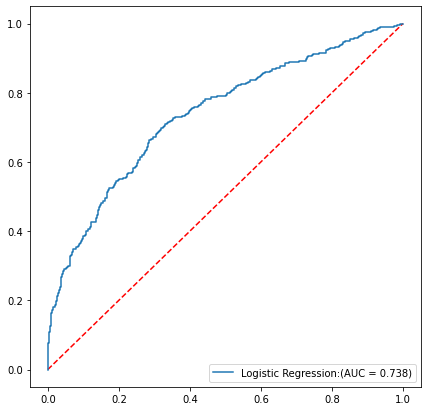

In [0]:
from sklearn.metrics import roc_curve, auc
y_pred = lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (7,7))
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr, tpr, label = 'Logistic Regression:(AUC = %0.3F)' % roc_auc)
plt.legend(loc = 'lower right')

In [0]:
prediction = []
for i in y_pred:
    if i<=0.5:
        prediction.append(0)
    else:
        prediction.append(1)

In [0]:
def cal_recall(prediction, y_test):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(prediction)):
        if prediction[i] == 1 and y_test[i] == 1:
            tp += 1
        if prediction[i] == 1 and y_test[i] == 0:
            fp += 1
        if prediction[i] == 0 and y_test[i] == 1:
            fn += 1
        if prediction[i] == 0 and y_test[i] == 0:
            tn += 1
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    return recall, precision, tp, fp, tn, fn


In [0]:
with open("logreg_pred_proba.pkl", "wb") as fout:
    pickle.dump(y_pred, fout)

In [0]:
recall = cal_recall(prediction, list(y_test))
print('Logistic Regression recall:', recall)

Logistic Regression recall: (0.6389413988657845, 0.6997929606625258, 338, 145, 374, 191)


## 2.2 SVM


In [80]:
print(x_train_std.shape, y.shape)

(2618, 97) (2618,)


In [85]:
from sklearn import svm
svm = svm.SVC(C=3, kernel='linear', probability = True)
svm.fit(x_train_std, y)

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

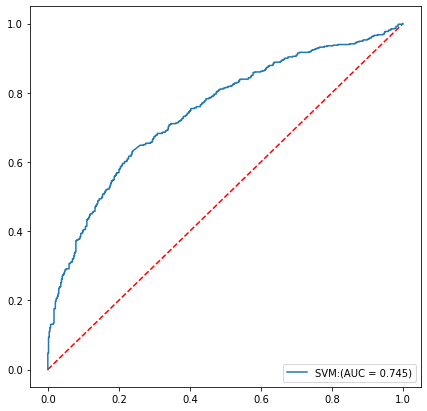

In [0]:
from sklearn.metrics import roc_curve, auc
y_pred = svm.predict_proba(x_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (7,7))
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr, tpr, label = 'SVM:(AUC = %0.3F)' % roc_auc)
plt.legend(loc = 'lower right')

In [0]:
with open("svm_pred_proba.pkl", "wb") as fout:
    pickle.dump(y_pred, fout)

In [0]:
prediction = []
for i in y_pred:
    if i<=0.5:
        prediction.append(0)
    else:
        prediction.append(1)

In [0]:
recall = cal_recall(prediction, list(y_test))
print('SVM recall:', recall)

SVM recall: (0.6313799621928167, 0.7292576419213974, 334, 124, 395, 195)


## 2.3 NN

In [0]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
def dftotensor(df):
    my_array = np.array(df)
    ten = torch.tensor(my_array)

    return ten

In [0]:
xtrain = dftotensor(x_train)
ytrain = dftotensor(y_train)

xtest = dftotensor(x_test)
ytest = dftotensor(y_test)
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

torch.Size([1570, 98]) torch.Size([1570]) torch.Size([1048, 98]) torch.Size([1048])


In [0]:
xtrain = xtrain.float()
ytrain = ytrain.float()
xtest = xtest.float()
ytest = ytest.float()

In [0]:
print(ytrain)

tensor([1., 0., 0.,  ..., 1., 0., 1.])


In [0]:
class Net(torch.nn.Module):  
    def __init__(self, n_feature, n_hidden, n_output):   
        super(Net, self).__init__()     
        self.hidden = torch.nn.Linear(n_feature, n_hidden)  
        #self.hidden1 = torch.nn.Linear(n_hidden, n_hidden) 
        self.predict = torch.nn.Linear(n_hidden, n_output)   
 
    def forward(self, x):   #3 hidden layers
        x = F.softplus(self.hidden(x))
        #x = F.relu(self.hidden1(x))
        #x = F.relu(self.hidden1(x))      
        x = F.softmax(self.predict(x))            
        return x
 
net = Net(n_feature=98, n_hidden=150, n_output=2)

In [0]:
optimizer = optim.Adam(net.parameters(),lr = 0.001, weight_decay = 0.1)
criterion = torch.nn.MSELoss() 

In [0]:
print(ytrain)

tensor([1., 0., 0.,  ..., 1., 0., 1.])


In [0]:
out = net(xtrain)[:,-1]
print(out.shape)
print(out)

torch.Size([1570])
tensor([0.5325, 0.5425, 0.5338,  ..., 0.5311, 0.5332, 0.5340],
       grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


avg train loss is 0.35435933021318383
avg test loss is 0.3952939808368683
avg train loss is 0.24978782938923805
avg test loss is 0.24995867908000946
avg train loss is 0.24999178840666061
avg test loss is 0.2500403821468353
avg train loss is 0.2499916906664326
avg test loss is 0.25004521012306213
avg train loss is 0.24999179406340716
avg test loss is 0.25004005432128906
avg train loss is 0.24999209364318545
avg test loss is 0.2500401437282562
avg train loss is 0.2499920921151046
avg test loss is 0.250039666891098
avg train loss is 0.24999197474710502
avg test loss is 0.25003746151924133
avg train loss is 0.24999211790265552
avg test loss is 0.2500540018081665
avg train loss is 0.2499919661860557
avg test loss is 0.2500576078891754


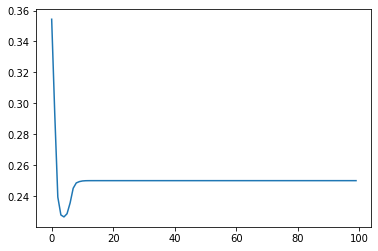

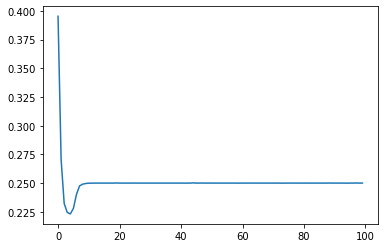

In [0]:
losslisttrain1 = []
losslistval1 = []

for epoch in range(100):
    avg_loss = 0
    ix_shuffle = np.arange(xtrain.shape[0])
    np.random.shuffle(ix_shuffle)
    ypred =  np.zeros(ytrain.shape)
    for ix in ix_shuffle:
        optimizer.zero_grad()
        x = xtrain
        target = ytrain
        #x = Variable(torch.from_numpy(xtrain[ix]))
        #target = Variable(torch.LongTensor(ytrain[ix]))
        out = net(x)[:,-1]
        ypred[ix] = out.data.numpy().ravel()[2]
        loss = criterion(out, target)
        avg_loss += loss.data.numpy().ravel()[0]
        loss.backward()
        optimizer.step()
    losslisttrain1.append(avg_loss/xtrain.shape[0])
    if epoch % 10 == 0:
        print('avg train loss is', avg_loss/xtrain.shape[0])
        #print('AUC train is:', roc_auc_score(y_true=(ytrain==2), y_score=ypred))

    ix_shuffle = np.arange(xtest.shape[0])
    np.random.shuffle(ix_shuffle)
    avg_loss = 0
    ypredtest = np.zeros(ytest.shape)
    for ix in ix_shuffle:
        #x = Variable(torch.from_numpy(xtest[ix]))
        #target = Variable(torch.LongTensor(ytest[ix]))
        x = xtest
        target = ytest
        out = net(x)[:,-1]
        ypredtest[ix] = out.data.numpy().ravel()[2]
        loss = criterion(out, target)
        avg_loss += loss.data.numpy().ravel()[0]
    losslistval1.append(avg_loss/xtest.shape[0])
    if epoch % 10 == 0:
        print('avg test loss is', avg_loss/xtest.shape[0])
        #print('AUC test is:', roc_auc_score(y_true=(ytest==2), y_score=ypredtest))

plt.plot(losslisttrain1); plt.show()
plt.plot(losslistval1); plt.show()

## 2.4 Perceptron

In [29]:
from sklearn.linear_model import Perceptron
pc = Perceptron(penalty = 'l2',alpha = 0.01)
pc.fit(x_train_std, y_train)

Perceptron(alpha=0.01, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
preds1 = pc.predict(x_missing_std)
print(Counter(preds1))

Counter({0: 436, 1: 93})


In [0]:
from sklearn import linear_model
from sklearn.datasets import make_classification
from sklearn.calibration import CalibratedClassifierCV
# Build a classification task using 3 informative features
X, y = make_classification(n_samples = 1570,
                           n_features=98,
                           n_classes=2,
                           n_redundant = 0,
                           random_state=0,
                           shuffle=False)

clf_isotonic = CalibratedClassifierCV(pc, method='sigmoid')

clf_isotonic.fit(x_train_std, y_train)

preds = clf_isotonic.predict_proba(x_missing_std)[:,-1]

In [34]:
#new 
prediction = []
for i in preds:
    if i>0.5:
        prediction.append(1)
    else:
        prediction.append(0)
print(Counter(prediction))

Counter({0: 438, 1: 91})


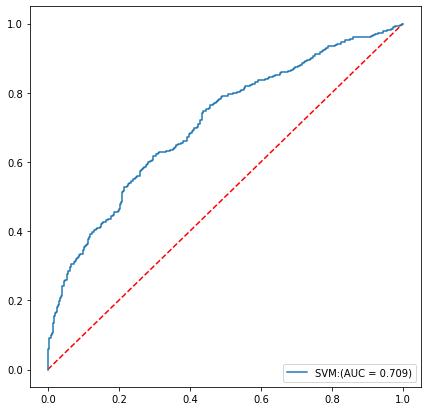

In [0]:
from sklearn.metrics import roc_curve, auc
#y_pred = pc.predict(x_test)
y_pred = preds[:,-1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (7,7))
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr, tpr, label = 'SVM:(AUC = %0.3F)' % roc_auc)
plt.legend(loc = 'lower right')

In [0]:
print(y_pred)

[0.50107673 0.48452863 0.53922081 ... 0.46152679 0.41972062 0.45369716]


In [0]:
prediction = []
for i in y_pred:
    if i<=0.5:
        prediction.append(0)
    else:
        prediction.append(1)

In [0]:
recall= cal_recall(prediction, list(y_test))
print('Perceptron recall/precision:', recall)

Perceptron recall/precision: (0.5897920604914934, 0.6842105263157895, 312, 144, 375, 217)


In [0]:
with open("perceptron_pred_proba.pkl", "wb") as fout:
    pickle.dump(y_pred, fout)

## 2.5 SVM-counties with 0 infection rate

In [0]:
#new
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x)
x_test_std = scaler.transform(x_test)

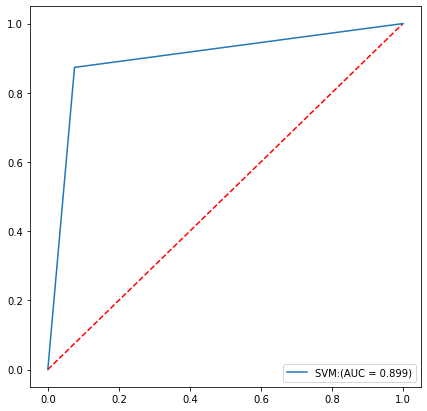

In [87]:
#new

from sklearn import svm
clf = svm.NuSVC(kernel = 'rbf')
clf.fit(x_train_std, y)

y_pred = clf.predict(x_test_std)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (7,7))
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr, tpr, label = 'SVM:(AUC = %0.3F)' % roc_auc)
plt.legend(loc = 'lower right')

In [88]:
#new
recall = cal_recall(y_pred, list(y_test))
print('SVM recall:', recall)

SVM recall: (0.8733459357277883, 0.9221556886227545, 462, 39, 480, 67)


In [0]:
#new
x_missing = missing.drop(['POPULATION','GEO_ID', 'COUNTY', 'STATE', 'INFECTION RATE'], axis = 1)
x_missing_std = scaler.transform(x_missing)

In [0]:
y_pred = clf.predict(x_missing_std)

In [94]:
from collections import Counter
print(Counter(y_pred))


Counter({0: 310, 1: 219})


In [99]:
temp = []
result = Counter(y_pred)
for i in range(len(y_pred)):
    if y_pred[i] ==1:
        temp.append(i)
print(len(temp))

219


In [0]:
test = missing.iloc[temp]
test.head()
t1 = test[['STATE','COUNTY']]
t1.to_csv('219.csv')

In [115]:
for i in temp:
    print(missing.iloc[i].COUNTY)

Geneva County
Aleutians East Borough
Aleutians West Census Area
Bristol Bay Borough
Denali Borough
Dillingham Census Area
Haines Borough
Hoonah-Angoon Census Area
Kodiak Island Borough
Kusilvak Census Area
Lake and Peninsula Borough
Nome Census Area
North Slope Borough
Northwest Arctic Borough
Sitka City and Borough
Skagway Municipality
Valdez-Cordova Census Area
Yakutat City and Borough
Jackson County
Little River County
Mariposa County
Sierra County
Trinity County
Conejos County
Dolores County
Jackson County
San Juan County
Glascock County
Montgomery County
Taliaferro County
Kalawao County
Clark County
Oneida County
Alexander County
Hardin County
Pope County
Cheyenne County
Clark County
Decatur County
Elk County
Graham County
Greeley County
Hodgeman County
Lincoln County
Ness County
Norton County
Rawlins County
Rush County
Russell County
Sherman County
Smith County
Carlisle County
Fulton County
Garrard County
Owen County
Owsley County
Trigg County
Wolfe County
Dukes County
Nantucket 

In [46]:
index = [0,134,141,145,148,158,169,207,208,210,314,315,316,317,367,408,492]
population = []
for i in index:
    population.append(int(missing.iloc[i].POPULATION))
cases = [22,1,16,1,8,6,2,3,33,103,0,0,0,0,30,10,0]
rate = []
for i in range(17):
    rate.append(cases[i]*100/population[i])
print(rate)
count = 0
for i in rate:
     if i>median:
        count +=1
print(count)




[0.08304707259069118, 0.0036780932764454905, 0.04332990304934193, 0.0036854131348124123, 0.02542345949725109, 0.02449079554267521, 0.005286250462546916, 0.008449038217816205, 0.08653921800015735, 0.35923549107142855, 0.0, 0.0, 0.0, 0.0, 0.04738737600303279, 0.030648522741203874, 0.0]
5
